# **Proyecto IA**

Laura Camila Rodriguez León y Mateo Vanegas de Correa

En el presente proyecto se desarrolló, entrenó y evaluó un agente del juego Connect4 utilizando Trial-Based Online Policy Improvement, MCTS, UCB y Softmax. Todo esto con el objetivo de crear un agente que fuera capaz de tomar decisiones racionales según la experiencia de su aprendizaje, y con esto lograra ganarle a cualquier rival. 

## 1. Primera versión del agente

En busca de solucionarlo, se implementó en la primera versión un agente MCTS que actuaba como una política, buscando que de esta forma pudiera utilizarse como un agente de RL. Esto funcionaba seleccionando una acción mediante el método select_action(state), el cual internamente realizaba el proceso de la busqueda Monte Carlo.

El MCTS contruía y actualizaba un árbol de búsqueda donde cada nodo representaba un estado del tablero y cada arista era una de las acciones posibles a realizar. En cada una de sus llamadas, el MCTS ejecuta varias fases(TBOPI): selección, expansión, simulación y retropropagación. 

Si llegaba a un nodo no explorado, empezaba la fase de expansión, donde se creaban nuevos nodos correspondientes a movimientos no visitados. Sin embargo, se encontró un error perjudicial para el aprendizaje del agente. En las simulaciones se observó lo siguiente:

```
[10/200] W_agente=5 W_oponente=5 D=0 win_rate_agente=0.500 
[20/200] W_agente=14 W_oponente=6 D=0 win_rate_agente=0.700 
[30/200] W_agente=18 W_oponente=12 D=0 win_rate_agente=0.600 
[40/200] W_agente=25 W_oponente=15 D=0 win_rate_agente=0.625 
[50/200] W_agente=35 W_oponente=15 D=0 win_rate_agente=0.700 
[60/200] W_agente=41 W_oponente=19 D=0 win_rate_agente=0.683 
[70/200] W_agente=42 W_oponente=28 D=0 win_rate_agente=0.600 
[80/200] W_agente=42 W_oponente=38 D=0 win_rate_agente=0.525 
[90/200] W_agente=47 W_oponente=43 D=0 win_rate_agente=0.522 
[100/200] W_agente=53 W_oponente=47 D=0 win_rate_agente=0.530 
[110/200] W_agente=57 W_oponente=53 D=0 win_rate_agente=0.518 
[120/200] W_agente=65 W_oponente=55 D=0 win_rate_agente=0.542 
[130/200] W_agente=74 W_oponente=56 D=0 win_rate_agente=0.569 
[140/200] W_agente=84 W_oponente=56 D=0 win_rate_agente=0.600 
[150/200] W_agente=94 W_oponente=56 D=0 win_rate_agente=0.627 
[160/200] W_agente=95 W_oponente=65 D=0 win_rate_agente=0.594 
[170/200] W_agente=95 W_oponente=75 D=0 win_rate_agente=0.559 
[180/200] W_agente=95 W_oponente=85 D=0 win_rate_agente=0.528 
[190/200] W_agente=100 W_oponente=90 D=0 win_rate_agente=0.526 
[200/200] W_agente=108 W_oponente=92 D=0 win_rate_agente=0.540
```

A pesar de que funcionaba, al momento de evaluarlo contra otros agentes que también estaban en sus procesos de aprendizaje, la brecha de aprendizaje era clara. De forma que, se llegó a la conclusión de que algo estaba fallando en el proceso. Retomando el comportamiento del TBOPI, podemos observar que la fase de simulación(rollout) jugaba aleatoriamente o seguía una política base hasta llegar a un estado terminal; y la retropropagación actualizaba los valores de victoria/visitas de todos los nodos por aquello que pasó en la simulación, reforzando los movimientos catalogados como útiles.

Cuando se completaban toda las simulaciones, el agente eleía la acción con mayor número de visitas en el árbol (o la mejor según la política configurable). 

El punto clave es que, el  MCTS no necesitaba de un modelo entrenado para pensar, sin embargo, el proyecto pide una combinación con una política aprendida desde JSON para mejorar las simulaciones. 

Sin embargo, en el único momento en el que la tabla de los Q-valores se actualizaba, era al momento de entrar en la retropropagación, por lo que se puede observar un problema base: no está aprendiendo realmente en las simulaciones. Por lo tanto, se decidió congelar ese primer modelo y aplicarle los cambios necesarios para optimizar el aprendizaje.

La segunda versión del agente fue con la misma base que el anterior, agregando partes claves, como la actualización de los Q-valores en cada una de las rondas de simulación para que de esta forma el agente se pueda mejorar a sí mismo paso a paso.

## 2. Segunda versión: TBOPI real (aprendizaje dentro de rollouts)

La segunda versión del agente se construyó sobre la misma base del MCTS, pero agregando una actualización directa de la Q-table durante cada rollout. La idea proviene de Trial-Based Online Policy Improvement: cada simulación no solo estima valores para el árbol local, sino que también mejora la política global tabular.

Matemáticamente, la tabla almacena una estimación de retorno terminal esperado:

$$
Q(s,a) \approx \mathbb{E}[G_t\mid s,a]
$$

Como Connect4 es episódico con recompensa terminal, el retorno es simplemente el resultado final \(R_T \in \{+1,0,-1\}\). Por ello, las actualizaciones se realizaron con un esquema Monte Carlo incremental:

$$
Q(s,a) \leftarrow Q(s,a) + \frac{r - Q(s,a)}{N(s,a)}
$$

donde \(r\) es la recompensa terminal observada y \(N(s,a)\) el número de veces que ese par fue visitado. Esto permite que la estimación converja a la media empírica de retornos.

Por lo tanto, se diseñó una política extendida llamada ```_default_policy_tbopi```, que funcionaba así:

1. Obtiene la clave única del estado actual.
2. Si existe información en la Q-table: Aplica un esquema ε-greedy, explotando la mejor acción según Q o explorando con probabilidad ε.
3. Si no hay Q-valores registrados: Usa la misma heurística original de MCTS.

Durante la simulación, la política guarda la trayectoria visitada como pares ```(state_key, action)```. Al terminar el episodio, calcula la recompensa terminal (+1 victoria, 0 empate, −1 derrota) y actualiza la Q-table mediante un esquema Monte Carlo: 

```
agent.update_q_with_terminal_reward(state_key, action, reward)
```

En resumen, la fase de simulación de MCTS deja de ser solo un mecanismo de búsqueda y se convierte en un proceso de aprendizaje continuo, donde cada rollout mejora los Q-valores.

Más tarde, para habilitar TBOPI e integrarlo dentro del MCTS, se modificó la función principal ```run_mcts_for_state``` para aceptar un parámetro opcional agent.

Así, tendremos los siguientes modos:

* *Modo MCTS puro (sin TBOPI):*
Si agent is None, se mantiene la política original basada solo en heurísticas. Este modo se usa para evaluación.

* *Modo MCTS + TBOPI:*
Si se pasa un agente, la simulación usa _default_policy_tbopi, alimentando y consultando los Q-valores en tiempo real.

Lo que cambia realmente gracias a este aporte es únicamente la lógica de simulación, que ahora combina heurística y aprendizaje.
Al finalizar, la función continuaban retornando la acción recomendada y las estadísticas de la raíz, que pueden emplearse para refinar también el valor Q del estado actual.

Durante el rollout TBOPI se aplicó una política epsilon-greedy basada en Q:

- Si existe información previa para el estado, se explota el mejor Q con probabilidad \(1-\epsilon\).
- Con probabilidad \(\epsilon\), se explora una acción legal aleatoria.
- En ausencia de Q, se usa la heurística clásica del rollout.



## 3. Configuración de experimentos

En esta sección se evalúa el desempeño del agente combinado Q(s,a) + MCTS bajo tres escenarios:

1. **Contra un jugador aleatorio (random):** para verificar que el agente supera claramente una política sin conocimiento.
2. **Self-play (agente vs agente):** para observar la estabilidad de la política cuando juega contra sí misma.
3. **Comparación con versiones anteriores del modelo:** para analizar si las sucesivas iteraciones del entrenamiento efectivamente mejoran la política.

En todos los casos se ejecutan partidas independientes, sin actualizar la Q-table (modo evaluación), y se registran las tasas de victoria, derrota y empate.

Para la segunda versión del modelo se observó lo siguiente:

```
Contra self_play: [600/600] W_train=328 W_opp=269 D=3 win_rate_train=0.547 

Contra random: 588 wins w_opp 10 D=2 win_rate= 0. 

Self_play(agente) vs random: [300/300] W_train=150 W_opp=150 D=0 win_rate_train=0.500
```

## 4. Tercera versión: Política Softmax sobre Q(s,a)

En busca de optimizar más el agente después de varias evaluaciones contra otros agentes, en donde parecía aprender menos, se decidió agregar Softmax en el entrenamiento. Lo esperado de esta nueva exploración es que durante el entrenamiento, cuando se tienen valores Q(s,a) para un estado, no se elija siempre el mejor. En su lugar, da la posibilidad de realizar una ruleta donde:

$$
P(a \mid s) \propto \exp\left(\frac{Q(s,a)}{\tau}\right)
$$

* si ${\tau}$ es muy grande, todas las acciones son igual de probables. Más exploración.
* si ${\tau}$ es muy pequeño, la estrategia es casi greedy, pues la mejor Q se lleva casi toda la probabilidad. Similar a argmax.

$$
p(a \mid s) = \frac{\exp\left(Q(s,a)/\tau\right)}{\sum_{a' \in A(s)} \exp\left(Q(s,a')/\tau\right)}
$$

Usando esto, podríamos sustituir ε-greedy por softmax sobre las Q(probabilidades de ganar). Y mostrar una acción según las probabilidades.

Por lo tanto, se modificó la forma en que el agente convierte los Q-valores en decisiones, tanto en las simulaciones como (parcialmente) en la fase de evaluación:


1. Política de simulación con Softmax
Dentro de la política _default_policy_tbopi, cuando el estado actual ya tiene Q(s,a) aprendidos para las acciones legales, en lugar de usar únicamente una regla ε-greedy se calcula primero la distribución softmax anterior y luego se muestra una acción según esas probabilidades.

* Si no existe información previa (estado nuevo en la Q-table), la simulación sigue usando la heurística original: intentar ganar en 1, bloquear mates en 1, favorecer el centro y, en último caso, jugar aleatorio.

* De esta forma, los rollouts siguen guiados por la experiencia acumulada en Q(s,a), pero mantienen un grado de exploración controlado por la temperatura τ, en lugar de colapsar siempre en la misma acción greedy.


2. Uso de Softmax sobre Q(s,a) frente a ε-greedy:

Conceptualmente, Softmax reemplaza el esquema de “explorar con probabilidad ε, explotar con probabilidad 1−ε” por una decisión más suave y continua:

* Acciones con Q muy alto reciben gran parte de la probabilidad, pero no el 100%.

* Acciones con Q intermedio siguen teniendo alguna probabilidad de ser elegidas, lo que permite descubrir líneas de juego alternativas que también funcionan bien.

* La temperatura τ permite ajustar este equilibrio sin tener que fijar explícitamente un ε.


3. Efecto global en el entrenamiento del agente:

Con esta tercera versión, cada simulación de MCTS sigue el esquema TBOPI (usa Q(s,a) y luego actualiza esos mismos Q con la recompensa terminal), pero ahora las decisiones dentro del rollout se toman con una política estocástica softmax. Esto tiene dos efectos principales:

* Evita que el agente se vuelva excesivamente determinista en estados donde solo ha visto unas pocas trayectorias, reduciendo el riesgo de sobreajustarse a líneas de juego específicas.

* Mantiene la explotación de buenas jugadas (Q altos) sin dejar de explorar otras opciones razonables, lo que en la práctica se tradujo en un comportamiento más robusto frente a otros agentes competitivos como el de Mari.

En resumen, la introducción de Softmax permitió que el agente no solo aprendiera Q(s,a) en cada rollout, sino que también los utilizara de forma probabilística e inteligente durante el entrenamiento, mejorando el equilibrio entre exploración y explotación sin depender exclusivamente de ε-greedy.


## 5. Discusiones sobre la optimización del agente

En el proceso de llegar al prototipo final, se realizó un intercambio de opiniones después de encontrar un error en la implementación, en el método ```default_policy_TBOPI```

```
#Recompensa terminal desde el punto de vista del root_player
winner = current get winner()
if winner == root_player:
    reward = 1.0
elif winner == 0:
    reward = 0.0
else:
    reward = -1.0

#Actualizar Q(s,a) para TODA la trayectoria (Monte Carlo)
for state_key, action in trayectory:
    agent.update_q_with_terminal_reward(state_key_action, reward)
```

El texto anterior fue el detonante. Se observó que se estaba premiando al agente cuando perdía. Y una de las soluciones planteadas fue intercambiar los jugadores por medio de invertir el signo modificando el método ```backup()``` que recibía de ```default_policy_TBOPI```. 

Se mencionó que cambiar el backup arreglaría los valores internos del árbol, pero no la Q-table que se está utilizando y se actualiza con ```update_q_with_terminal_reward```.

Hasta ese momento, el flujo del programa hacia lo siguiente:

* Por cada movimiento crea un árbol local, cada rollout actualiza ese árbol, para saber cómo seguir con la simulación llama al método de TBOPI.

* TBOPI simula hasta el estado terminal y realiza dos acciones, primero actualiza la Q-table global con el reward, más tarde le retorna la reward al backup.

* Cuando se actualizo la Q-table global se realizaba con recompensas cruzadas.

* Cuando backup recibe la recompensa actualiza solo el arbol local, pero ese arbol muere despues de cada movimiento.

Por ende, el árbol local quedaba mal entrenado y por consiguiente, la Q-table también. 

La solución encontrada al problema fue cambiar el método de TBOPI al igual que el backup, teniendo en cuenta que los rewards que se estaban  enviando estaban mal calculados.


## Prototipo final: política Softmax sobre Q(s,a)

Una vez corregido el reward local, la arquitectura se consolidó en un prototipo final en el que todas implementaciones se integran bien: MCTS se usa como motor de búsqueda por turno, `default policy tbopi` actualiza la Q-table global en cada rollout y la política de decisión se basa en Softmax sobre \(Q(s,a)\) con temperatura tau. En entrenamiento, el flujo es siempre el mismo: en cada movimiento del agente se lanza un MCTS con TBOPI, los rollouts exploran el espacio de jugadas usando Softmax (combinado con las heurísticas de ganar/bloquear en 1) y, al finalizar cada simulación, se actualizan los pares \((s,a)\) visitados con la recompensa terminal correcta desde el punto de vista del jugador que actuó en ese estado. El árbol local se descarta después de cada jugada, pero la información útil queda almacenada de forma acumulativa en la Q-table en disco.

Sobre esta base se entrenaron dos variantes finales, etiquetadas como **VS1_Mejorada** y **VS2_Mejorada**. Ambas comparten el mismo pipeline general, pero **VS1_Mejorada** corresponde a la versión entrenada *antes* de mejorar al adversario en el entrenamiento: en esa etapa el backup de recompensas del árbol MCTS y la política `_default_policy_tbopi` todavía usaban el esquema original, en el que la reward se propagaba de forma incorrecta a todos los nodos. **VS2_Mejorada**, en cambio, repite el mismo flujo pero con el adversario ya corregido: el backup de cada nodo y TBOPI actualizan la Q-table usando la recompensa calculada desde el punto de vista del jugador que realizó cada jugada. En ambos casos el entrenamiento se realizó en escenarios competitivos (self-play y contra una política congelada), registrando periódicamente el winrate del agente entrenado frente a su oponente; estos valores se volcaron en `logs/train/winrate1.txt` y `logs/train/winrate2.txt` y se usaron para construir las curvas de aprendizaje.


Las primeras curvas muestran que **VS1_Mejorada** se estabiliza rápidamente alrededor de un winrate cercano a 0.46–0.50, sin lograr una mejora sostenida a lo largo de los episodios. En contraste, **VS2_Mejorada** arranca en torno a \(0.5\) pero exhibe una tendencia claramente ascendente: supera el 0.7 después de varios cientos de episodios, se mantiene en la franja 0.75–0.85 durante buena parte del entrenamiento y, en la etapa final, alcanza valores cercanos a **0.96** frente al oponente usado en entrenamiento. La versión suavizada con promedio móvil confirma que no se trata de ruido puntual, sino de una mejora progresiva y estable de la política.

La gráfica de **mejora relativa**

$$
\Delta \text{winrate} = \text{VS2} - \text{VS1}
$$
resume este efecto: tras algunos episodios iniciales donde ambas versiones son comparables, la diferencia se vuelve positiva y crece de forma casi monótona hasta situarse por encima de **0.5**. Es decir, para un mismo número de episodios, VS2_Mejorada gana del orden de 50 puntos porcentuales más que VS1_Mejorada frente al mismo tipo de rival. Finalmente, el gráfico de barras de winrate final sintetiza el resultado: la primera versión mejorada cierra alrededor de **0.458**, mientras que el prototipo final alcanza aproximadamente **0.965**, lo que indica un dominio casi total en el entorno de evaluación usado.

En conjunto, estas evidencias empíricas muestran que el **prototipo final** MCTS + TBOPI con actualización correcta de recompensas y política Softmax sobre \(Q(s,a)\) sí logra el comportamiento buscado en el proyecto: un agente que aprende de sus propias simulaciones, explota de forma inteligente el conocimiento acumulado y, al mismo tiempo, mantiene suficiente exploración para seguir mejorando hasta alcanzar tasas de victoria cercanas al 100 % frente a oponentes del tipo considerado.



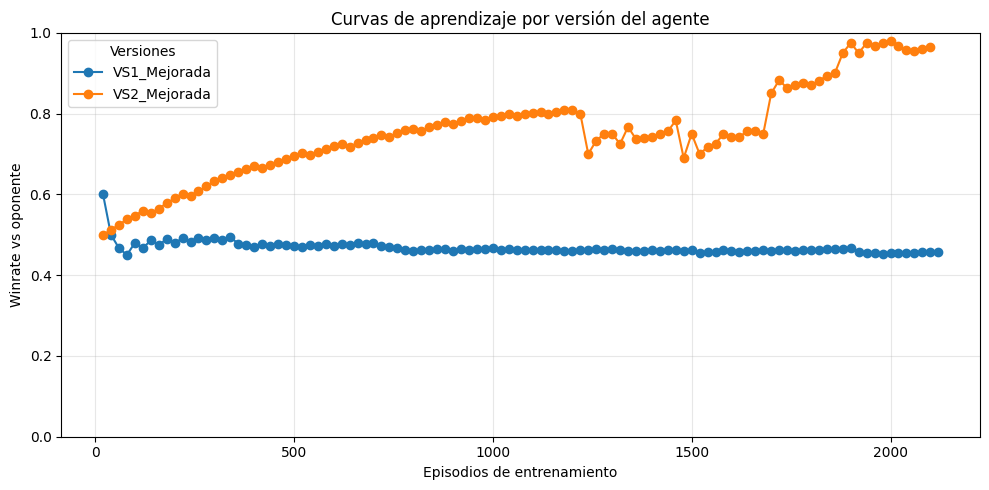

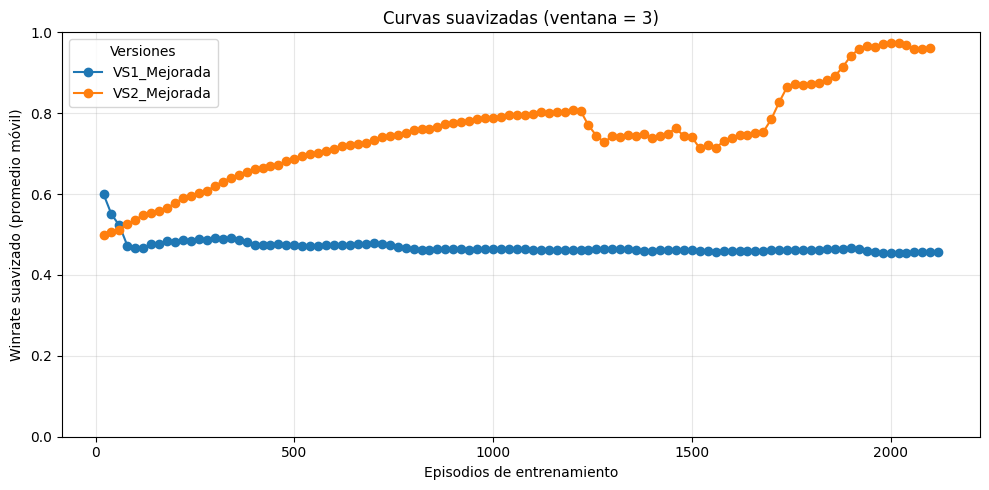

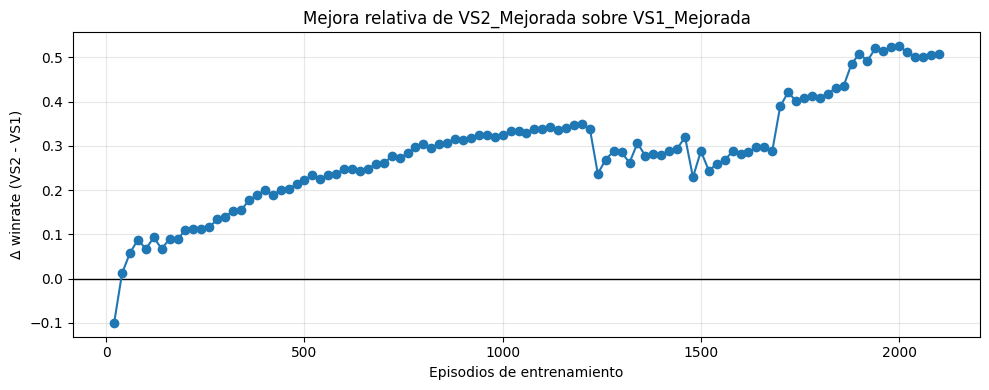

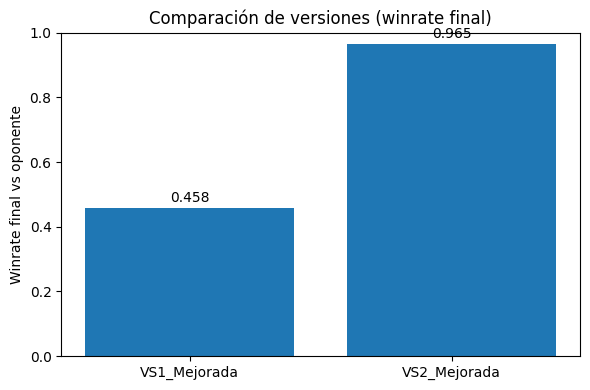

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


#  Helpers base: leer winrates de logs/train 

def load_winrates(path, step: int = 20):
    """
    Lee un archivo donde cada línea es un winrate (float).
    Devuelve:
      - episodios: [step, 2*step, 3*step, ...]
      - winrates:  lista de floats
    """
    path = Path(path)
    winrates: list[float] = []

    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                winrates.append(float(line))
            except ValueError:
                continue

    episodios = [step * (i + 1) for i in range(len(winrates))]
    return episodios, winrates


def _find_logs_train_dir():
    base = Path.cwd()
    candidates = [
        base / "logs" / "train",
        base.parent / "logs" / "train",
        base.parent.parent / "logs" / "train",
    ]
    for c in candidates:
        if c.exists():
            return c
    raise FileNotFoundError("No se encontró 'logs/train' cerca del notebook.")


#  1) Curvas “crudas” 

def plot_training_winrates(
    log_dir=None,
    files=("winrate1.txt", "winrate2.txt"),
    labels=("VS1_Mejorada", "VS2_Mejorada"),
    steps=(20, 20),
):
    if log_dir is None:
        log_dir = _find_logs_train_dir()
    else:
        log_dir = Path(log_dir)

    plt.figure(figsize=(10, 5))

    for fname, label, step in zip(files, labels, steps):
        episodios, winrates = load_winrates(log_dir / fname, step=step)
        plt.plot(episodios, winrates, marker="o", linestyle="-", label=label)

    plt.xlabel("Episodios de entrenamiento")
    plt.ylabel("Winrate vs oponente")
    plt.ylim(0.0, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Versiones")
    plt.title("Curvas de aprendizaje por versión del agente")
    plt.tight_layout()
    plt.show()


#  2) Curvas suavizadas 

def moving_average(values, window: int = 3):
    """Promedio móvil simple (ventana hacia atrás)."""
    values = np.asarray(values, dtype=float)
    smoothed = []
    for i in range(len(values)):
        start = max(0, i - window + 1)
        smoothed.append(values[start : i + 1].mean())
    return smoothed


def plot_smoothed_winrates(
    log_dir=None,
    files=("winrate1.txt", "winrate2.txt"),
    labels=("VS1_Mejorada", "VS2_Mejorada"),
    steps=(20, 20),
    window: int = 3,
):
    """
    Curvas suavizadas -> sirve para la parte de “validación del agente”
    porque muestra estabilidad del rendimiento en el tiempo.
    """
    if log_dir is None:
        log_dir = _find_logs_train_dir()
    else:
        log_dir = Path(log_dir)

    plt.figure(figsize=(10, 5))

    for fname, label, step in zip(files, labels, steps):
        episodios, winrates = load_winrates(log_dir / fname, step=step)
        winrates_smooth = moving_average(winrates, window=window)
        plt.plot(episodios, winrates_smooth, marker="o", linestyle="-", label=label)

    plt.xlabel("Episodios de entrenamiento")
    plt.ylabel("Winrate suavizado (promedio móvil)")
    plt.ylim(0.0, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Versiones")
    plt.title(f"Curvas suavizadas (ventana = {window})")
    plt.tight_layout()
    plt.show()


#  3) Curva de mejora relativa VS2 - VS1 

def plot_improvement_curve(
    log_dir=None,
    file_base="winrate1.txt",
    file_new="winrate2.txt",
    step_base: int = 20,
    step_new: int = 20,
    label_base="VS1_Mejorada",
    label_new="VS2_Mejorada",
):
    """
    Muestra Δ winrate = VS2 - VS1 por checkpoint -> parte fuerte para rúbrica 3 (optimización).
    """
    if log_dir is None:
        log_dir = _find_logs_train_dir()
    else:
        log_dir = Path(log_dir)

    ep1, wr1 = load_winrates(log_dir / file_base, step=step_base)
    ep2, wr2 = load_winrates(log_dir / file_new, step=step_new)

    # Alinear por longitud mínima
    k = min(len(wr1), len(wr2))
    wr1 = np.array(wr1[:k])
    wr2 = np.array(wr2[:k])
    episodios = ep1[:k]  # asumimos mismo step

    delta = wr2 - wr1

    plt.figure(figsize=(10, 4))
    plt.axhline(0.0, color="black", linewidth=1)
    plt.plot(episodios, delta, marker="o", linestyle="-")
    plt.xlabel("Episodios de entrenamiento")
    plt.ylabel("Δ winrate (VS2 - VS1)")
    plt.title(f"Mejora relativa de {label_new} sobre {label_base}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


#  4) Barras con winrate final de cada versión 

def plot_final_winrate_bar(
    log_dir=None,
    files=("winrate1.txt", "winrate2.txt"),
    labels=("VS1_Mejorada", "VS2_Mejorada"),
):
    """
    Gráfico de barras del winrate final de cada versión -> comparación clara de configuraciones.
    """
    if log_dir is None:
        log_dir = _find_logs_train_dir()
    else:
        log_dir = Path(log_dir)

    finals = []
    for fname in files:
        _, wr = load_winrates(log_dir / fname, step=1)
        finals.append(wr[-1] if wr else 0.0)

    x = np.arange(len(labels))

    plt.figure(figsize=(6, 4))
    plt.bar(x, finals)
    plt.xticks(x, labels)
    plt.ylim(0.0, 1.0)
    for xi, val in zip(x, finals):
        plt.text(xi, val + 0.01, f"{val:.3f}", ha="center", va="bottom")
    plt.ylabel("Winrate final vs oponente")
    plt.title("Comparación de versiones (winrate final)")
    plt.tight_layout()
    plt.show()



plot_training_winrates()
plot_smoothed_winrates(window=3)
plot_improvement_curve()
plot_final_winrate_bar()
